# Performance variance in a simple problem

A key thing to understand is that **computers are not a box that does arithmetic at a fixed rate**.  There is a **huge variance** in performance depending on **how the "same" algorithm is implemented**, both *within a single language* and when *comparing different languages*.

First, we will look at a simple algorithm for a simple function — summation of *n* numbers — and see how the "same" calculation can vary in performance by **orders of magnitude**.

The next task is to understand *why* this variation occurs, which is essential to making sure that your own code is fast and not slow!    More detail can be found in the accompanying [Boxes and registers](Boxes-and-registers.ipynb) notes.

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.271846  
 0.358779  
 0.890233  
 0.0790911 
 0.00939895
 0.767968  
 0.308546  
 0.322207  
 0.925622  
 0.798759  
 0.964225  
 0.89269   
 0.347821  
 ⋮         
 0.273381  
 0.121823  
 0.573685  
 0.960718  
 0.598456  
 0.0506493 
 0.18194   
 0.726292  
 0.14169   
 0.384121  
 0.553164  
 0.838971  

In [2]:
sum(a)

5.000180786929853e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [3]:
#Pkg.add("BenchmarkTools")

In [4]:
using BenchmarkTools, Compat

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [5]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [6]:
c_sum(a)

5.000180786930093e6

In [7]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [8]:
c_sum(a) - sum(a)  

2.39349901676178e-7

In [9]:
≈  # alias for the `isapprox` function

isapprox (generic function with 3 methods)

In [10]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=sqrt(eps), atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= atol + rtol*max(norm(x), norm(y))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, `rtol` defaults to `sqrt(eps(typeof(real(x-y))))`. This corresponds to requiring equality of about half of the significand digits. For other types, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true
```


We can now benchmark the C code directly from Julia:

In [11]:
c_bench = @benchmark c_sum($a) 

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.856 ms (0.00% GC)
  median time:      10.049 ms (0.00% GC)
  mean time:        10.233 ms (0.00% GC)
  maximum time:     12.929 ms (0.00% GC)
  --------------
  samples:          488
  evals/sample:     1

In [12]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 9.855969 msec


In [13]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 9.85597

In [14]:
#Pkg.add("PyPlot")
using PyPlot

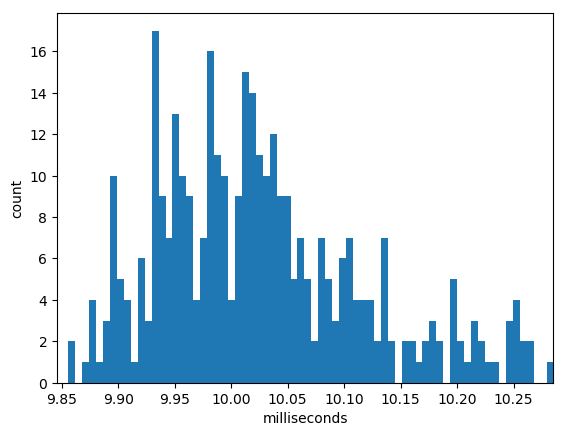

PyObject Text(24,0.5,u'count')

In [15]:
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

plt[:hist](t, bins=500)
xlim(m - 0.01, m + σ),
xlabel("milliseconds")
ylabel("count")

# 2. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [16]:
#Pkg.add("PyCall")
using PyCall

In [17]:
# Call a low-level PyCall function to get a Python list, because
# by default PyCall will convert to a NumPy array instead (we benchmark NumPy below):

apy_list = PyCall.array2py(a, 1, 1)

# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [18]:
pysum(a)

5.000180786930093e6

In [19]:
pysum(a) ≈ sum(a)

true

In [20]:
py_list_bench = @benchmark $pysum($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  17
  --------------
  minimum time:     101.583 ms (0.00% GC)
  median time:      102.946 ms (0.00% GC)
  mean time:        103.999 ms (0.00% GC)
  maximum time:     112.713 ms (0.00% GC)
  --------------
  samples:          49
  evals/sample:     1

In [21]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 2 entries:
  "C"               => 9.85597
  "Python built-in" => 101.583

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [22]:
numpy_sum = pyimport("numpy")["sum"]
apy_numpy = PyObject(a) # converts to a numpy array by default

py_numpy_bench = @benchmark $numpy_sum($apy_numpy)

BenchmarkTools.Trial: 
  memory estimate:  720 bytes
  allocs estimate:  22
  --------------
  minimum time:     6.388 ms (0.00% GC)
  median time:      6.545 ms (0.00% GC)
  mean time:        6.642 ms (0.00% GC)
  maximum time:     9.712 ms (0.00% GC)
  --------------
  samples:          751
  evals/sample:     1

In [23]:
numpy_sum(apy_list) # python thing

5.000180786929854e6

In [24]:
numpy_sum(apy_list) ≈ sum(a)

true

In [25]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 9.85597
  "Python numpy"    => 6.38756
  "Python built-in" => 101.583

# 4. Python, hand-written 

In [26]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x13b615938>

In [27]:
py_hand = @benchmark $sum_py($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  17
  --------------
  minimum time:     1.446 s (0.00% GC)
  median time:      1.449 s (0.00% GC)
  mean time:        1.452 s (0.00% GC)
  maximum time:     1.466 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [28]:
sum_py(apy_list)

5.000180786930093e6

In [29]:
sum_py(apy_list) ≈ sum(a)

true

In [30]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                   => 9.85597
  "Python numpy"        => 6.38756
  "Python hand-written" => 1445.53
  "Python built-in"     => 101.583

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [31]:
@which sum(a)

sum(a) in Base at reduce.jl:359

In [32]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.441 ms (0.00% GC)
  median time:      6.638 ms (0.00% GC)
  mean time:        6.884 ms (0.00% GC)
  maximum time:     10.581 ms (0.00% GC)
  --------------
  samples:          725
  evals/sample:     1

In [33]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 9.85597
  "Python numpy"        => 6.38756
  "Python hand-written" => 1445.53
  "Python built-in"     => 101.583
  "Julia built-in"      => 6.44099

# 6. Julia (hand-written) 

In [34]:
function mysum(A)   
    s = 0.0  # s = zero(eltype(A))
    for a in A   
        s += a   
    end
    s
end

mysum (generic function with 1 method)

In [35]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.150 ms (0.00% GC)
  median time:      10.365 ms (0.00% GC)
  mean time:        10.546 ms (0.00% GC)
  maximum time:     13.060 ms (0.00% GC)
  --------------
  samples:          474
  evals/sample:     1

In [36]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 9.85597
  "Python numpy"        => 6.38756
  "Julia hand-written"  => 10.1501
  "Python hand-written" => 1445.53
  "Python built-in"     => 101.583
  "Julia built-in"      => 6.44099

# Summary

In [38]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value, 2), 10, "."))
end

Python numpy..............6.39
Julia built-in............6.44
C.........................9.86
Julia hand-written.......10.15
Python built-in.........101.58
Python hand-written....1445.53
